## High-Temperature Pressure calculation for dDAC data

Authors: Biao Wang* and Christian Plückthun, Hauke Marquardt

Biao Wang writes the script; Christian Plückthun provides his code as an reference; Hauke Marquardt helps with the methodology and helps to check the accuracy of the calculations

email: biao.wang@earth.ox.ac.uk

Last update: 2021.11.30

### import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy.constants import Avogadro 
from scipy.constants import gas_constant

### bulid functions for further use

In [2]:
#############################  3rd BM EoS + Mie-Grüneisen-Relation = high-T Eos  ####################################################
lam = 0.4836                     
""" Below you need to modify the parameters for your pressure standard """
V0 = 67.85                       # Au, Fei et al., 2007
K0 = 167                         # Au, Fei et al., 2007
K0der = 5.77                     # Au, Fei et al., 2007
Gruneisen_V0 = 2.97              # Au, Fei et al., 2007
q = 0.6                          # Au, Fei et al., 2007
Debye_temperature_V0 = 170       # Au, Fei et al., 2007
""" Above you need to modify the parameters for your pressure standard """
n=1
Z = 4                     
def P_HT(twotheta, h, k, l, T):
    d = lam / (2 * np.sin(0.5 * twotheta * np.pi /180) )     
    a = np.sqrt(h**2 + k**2 + l**2) * d                      
    V = a**3                                                 
    P_300K = 3/2 * K0 * ((V0/V)**(7/3) - (V0/V)**(5/3)) * (1 - 3/4 * (4 - K0der) * ((V0/V)**(2/3) - 1))
    def Debye_Fun(x):
        for parameter in range(0,len(x)):
            if x[parameter] == 0:
                D = 1
            elif x[parameter] > 0 and x[parameter] <= 0.1:
                D = 1-0.375*x+x**2*(0.05-5.952380953*10**(-4)*x**2)
            elif x[parameter] > 0.1 and x[parameter] <= 7.25:
                D = ((((0.0946173*x-4.432582)*x+85.07724)*x-800.6087)*x+3953.632)/((((x+15.121491)*x+143.155337)*x+682.0012)*x+3953.632)
            elif x[parameter] > 7.25:
                N=25/x
                D = 0
                D2 = 1
                if x[parameter] <= 25:
                    for i in range(1,math.floor(N)):  #based on a matlab code, have to see if this would work!!! Still needs testing!!!
                        D2 = D2*np.exp(-x)
                        x3 = i*x
                        D = D + D2*((6+x3*(6+x3*(6+x3*(3+x3))))/(1/N**4))
                    D = 3*((6.493939402-D)/x**3)    
                if x[parameter] > 25:
                    D = 3*((6.493939402-D)/x**3)
            else:
                print('something went wrong!')
            return D
    Gruneisen_V = Gruneisen_V0*(V/V0)**q
    Debye_temperature_V = Debye_temperature_V0*(V/V0)**(-Gruneisen_V)
    Debye_Fun_300K = Debye_Fun(Debye_temperature_V/300)
    Debye_Fun_HT = Debye_Fun(Debye_temperature_V/T)
    E_300K = 3*n*gas_constant*300*Debye_Fun_300K
    E_th = 3*n*gas_constant*T*Debye_Fun_HT
    P_th = (Gruneisen_V/((V/Z)*(10**-30)*Avogadro)) * (E_th - E_300K)
    P_th = P_th/10**9
    P = P_300K + P_th
    return P
############################ 3rd order Birch-Murnaghan Equation of State at room Temperature####################################
lam = 0.4836                     
""" Below you need to modify the parameters for your pressure standard """
V0 = 67.85                       # Au, Fei et al., 2007
K0 = 167                         # Au, Fei et al., 2007
K0der = 5.77                     # Au, Fei et al., 2007
""" Above you need to modify the parameters for your pressure standard """
def P_300K_BM(twotheta, h, k, l):
    d = lam / (2 * np.sin(0.5 * twotheta * np.pi /180) )
    a = np.sqrt(h**2 + k**2 + l**2) * d 
    V = a**3 
    P = 3/2 * K0 * ((V0/V)**(7/3) - (V0/V)**(5/3)) * (1 - 3/4 * (4 - K0der) * ((V0/V)**(2/3) - 1))
    return P

### import 2-theta of pressure standard from fitResults

In [3]:
df_L1 = pd.read_excel(r'HO2_450K_fitResults.xlsx', sheet_name='L1_2thetas')
df_L2 = pd.read_excel(r'HO2_450K_fitResults.xlsx', sheet_name='L2_2thetas')

In [4]:
fn_L1 = df_L1.fn.to_numpy()
au_111_L1 = df_L1.au_111.to_numpy()
fn_L2 = df_L2.fn.to_numpy()
au_111_L2 = df_L2.au_111.to_numpy()

### calculate the pressure using the defined function (have to input 2-theta, hkl and temperature)

In [5]:
P_L1_HT = P_HT(au_111_L1, 1, 1, 1, 450) # T in K!!!!
P_L1_300K = P_300K_BM(au_111_L1, 1, 1, 1)
P_L1_th = P_L1_HT - P_L1_300K

P_L2_HT = P_HT(au_111_L2, 1, 1, 1, 450)
P_L2_300K = P_300K_BM(au_111_L2, 1, 1, 1)
P_L2_th = P_L2_HT - P_L2_300K

### plot the pressure as function of file number

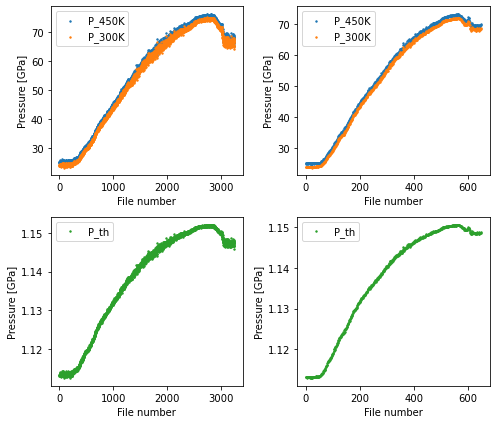

In [6]:
plt.close()
fig = plt.figure(figsize=(7,6))
gs = gridspec.GridSpec(2,2)

ax0 = fig.add_subplot(gs[0])
ax0.scatter(fn_L1, P_L1_HT, s=2, c='C0', label='P_450K')
ax0.scatter(fn_L1, P_L1_300K, s=2, c='C1', label='P_300K')
ax0.legend()
ax0.set_xlabel('File number')
ax0.set_ylabel('Pressure [GPa]')

ax1 = fig.add_subplot(gs[1])
ax1.scatter(fn_L2, P_L2_HT, s=2, c='C0', label='P_450K')
ax1.scatter(fn_L2, P_L2_300K, s=2, c='C1', label='P_300K')
ax1.legend()
ax1.set_xlabel('File number')
ax1.set_ylabel('Pressure [GPa]')

ax2 = fig.add_subplot(gs[2])
ax2.scatter(fn_L1, P_L1_th, s=2, c='C2', label='P_th')
ax2.legend()
ax2.set_xlabel('File number')
ax2.set_ylabel('Pressure [GPa]')

ax3 = fig.add_subplot(gs[3])
ax3.scatter(fn_L2, P_L2_th, s=2, c='C2', label='P_th')
ax3.legend()
ax3.set_xlabel('File number')
ax3.set_ylabel('Pressure [GPa]')

fig.tight_layout()

### export the calculated pressure

In [7]:
results = {'col1': P_L1_HT, 'col2': P_L1_300K, 'col3': P_L1_th}
results = pd.DataFrame(results)
np.savetxt('calculated_pressure_L1.csv', results, delimiter=',', header='P_L1_HT, P_L1_300K, P_L1_th')
os.startfile('calculated_pressure_L1.csv')

In [8]:
results = {'coL2': P_L2_HT, 'col2': P_L2_300K, 'col3': P_L2_th}
results = pd.DataFrame(results)
np.savetxt('calculated_pressure_L2.csv', results, delimiter=',', header='P_L2_HT, P_L2_300K, P_L2_th')
os.startfile('calculated_pressure_L2.csv')